Just went over Binomial Distributions for Bernoulli Random Variables in the workshop today.
One way I can apply this stuff is with the Kill Team game I have been investigating.
I want to determine the chance that a given model is able to hit and wound a different model.

The first thing to do is to define the rules.
Then I can simulate the situation.
Then I can try to derive the probabilities using the stuff that we went over.

---

### Simulation

The sequence of events is:

* Roll to Hit.
  This uses the Ballistic Skill of the attacker and any penalties.
  A roll higher than the threshold will hit.

* Roll to Wound.
  This compares the Strength of the attack to the Toughness of the defender.

Attack Strength vs Target Toughness | D6 Roll Required
------------------------------------|-----------------
Strength >= 2 x Toughness | 2+
Strength > Toughness | 3+
Strength == Toughness | 4+
Strength < Toughness | 5+
2 x Strength <= Toughness | 6+

* Roll to Save.
  This uses the Save of the defender minus the Armour Piercing of the attack.
  Invulnerable Saves are not reduced by Armour Piercing and will be used when better.

* Roll to Injure.
  If a model is reduced to 0 wounds by an attack, or receives an attack at 0 wounds, then they are injured.
  If they roll a 3 or less then they suffer a flesh wound.
  Each existing flesh wound increases the injury roll by 1.

The Plague Marine will be the attacker.

Name | Movement | Weapon Skill | Ballistic Skill | Strength | Toughness | Wounds | Attacks | Leadership | Save | Maximum Count
-----|----------|--------------|-----------------|----------|-----------|--------|---------|------------|------|--------------
Plague Marine | 5" | 3+ | 3+ | 4 | 5 | 1 | 1 | 7 | 3+ | -
Plague Marine Gunner | 5" | 3+ | 3+ | 4 | 5 | 1 | 1 | 7 | 3+ | 2
Plague Marine Fighter | 5" | 3+ | 3+ | 4 | 5 | 1 | 2 | 7 | 3+ | 2
Plague Champion | 5" | 3+ | 3+ | 4 | 5 | 1 | 2 | 8 | 3+ | 1

The Plague Marine has a boltgun.

Weapon | Range | Type | Strength | Armour Piercing | Damage | Abilities
-------|-------|------|----------|-----------------|--------|----------
Boltgun | 24" | Rapid Fire 1 | 4 | 0 | 1 | -

* Rapid Fire weapons fire double the number of shots when the targets are within half the range.
* Targets that are at long range (more than half the range) suffer a -1 penalty to hit.


The Harlequin will be the defender.

Name | Movement | Weapon Skill | Ballistic Skill | Strength | Toughness | Wounds | Attacks | Leadership | Save | Maximum Count
-----|----------|--------------|-----------------|----------|-----------|--------|---------|------------|------|--------------
Player | 8" | 3+ | 3+ | 3 | 3 | 1 | 4 | 8 | 6+ | -

Due to the Holo-suit the Harlequin has a 4+ invulnerable save.

This means that the attack resolves as:

**Long Range**

* 1 Attack
* Roll to Hit: 4+
* Roll to Wound: 3+
* Roll to Save: 4+

**Short Range**

* 2 Attacks
* Roll to Hit: 3+
* Roll to Wound: 3+
* Roll to Save: 4+

In [36]:
from dataclasses import dataclass
from typing import List, Set, Tuple
from random import choice

import pandas as pd
import requests
from bs4 import BeautifulSoup
import bs4

In [3]:
def d6():
    return choice(list(range(1, 7)))

def long_range_attack(rows: int = 10_000):
    df = pd.DataFrame(
        {
            'hit': [d6() for _ in range(rows)],
            'wound': [d6() for _ in range(rows)],
            'save': [d6() for _ in range(rows)],
            'injure': [d6() for _ in range(rows)]
        }
    )
    df['killed'] = (df['hit'] >= 4) & (df['wound'] >= 3) & (df['save'] < 4) & (df['injure'] > 3)
    return df

def short_range_attack(rows: int = 10_000):
    df = pd.DataFrame(
        {
            'hit': [[d6(), d6()] for _ in range(rows)],
            'wound': [[d6(), d6()] for _ in range(rows)],
            'save': [[d6(), d6()] for _ in range(rows)],
            'injure': [[d6(), d6()] for _ in range(rows)]
        }
    )
    df['wound'] = df.apply(lambda row: ([
        (row['hit'][i] >= 3) and (row['wound'][i] >= 3) and (row['save'][i] < 4)
        for i in range(2)
    ]), axis=1)
    df['killed'] = df.apply(lambda row: max(row['wound'][i] * row['injure'][i] for i in range(2)) > 3, axis=1)
    return df

In [4]:
long_range_df = long_range_attack()

long_range_df['killed'].sum() / len(long_range_df)

0.0868

In [5]:
short_range_df = short_range_attack()

short_range_df['killed'].sum() / len(short_range_df)

0.2083

In [166]:
def attack(rows: int = 10_000, attacks: int = 1, to_hit: int = 3, to_wound: int = 3, save: int = 4) -> pd.DataFrame:
    df = pd.DataFrame(
        [
            {
                'row': row,
                'attack': attack,
                'hit': d6(),
                'wound': d6(),
                'save': d6(),
                'injure': d6()
            }
            for row in range(rows)
            for attack in range(attacks)
        ]
    ).set_index(['row', 'attack'])
    df['hurt'] = (
        (df['hit'] >= to_hit) &
        (df['wound'] >= to_wound) &
        (df['save'] < save)
    )
    df['killed'] = df['hurt'] & (df['injure'] > 3)
    return df

def summarize(df: pd.DataFrame) -> Tuple[float, float]:
    df = df.drop(columns=['hit', 'wound', 'save', 'injure'])
    count = df.index.max()[0] + 1
    hurt_probability = (
        df
            .drop(columns='killed')
            .groupby(level=0)
            .agg(max)
            .sum()
            .iat[0]
    ) / count
    kill_probability = (
        df
            .drop(columns='hurt')
            .groupby(level=0)
            .agg(max)
            .sum()
            .iat[0]
    ) / count
    return hurt_probability, kill_probability

In [167]:
short_range_df_2 = attack(attacks=2)

short_range_df_2.head()

hit  wound  save  injure   hurt  killed
row attack                                         
0   0         4      1     4       5  False   False
    1         3      2     2       1  False   False
1   0         1      3     6       1  False   False
    1         4      6     1       6   True    True
2   0         2      1     3       6  False   False

In [168]:
(
    short_range_df_2
        .drop(columns=['hit', 'wound', 'save', 'injure'])
        .groupby(level=0)
        .agg(max)
        .sum()
), short_range_df_2.index.max()

(hurt      3931
 killed    2097
 dtype: int64, (9999, 1))

In [170]:
hurt, killed = summarize(short_range_df_2)
print(f'Short Range: {hurt} hurt, {killed} killed')

Short Range: 0.3931 hurt, 0.2097 killed


At this point I have the start of a simulation. I now need to compare:
* All plague weapons vs Harlequins
* All harlequin weapons vs plague marine types
* Same as above for close combat
* Same as above for poxwalkers
* Consider different to modifiers (cover, long range etc)

The datafiles for these kill teams are available [on github](https://github.com/BSData/wh40k-killteam). They are XML files.

* [Death Guard](https://raw.githubusercontent.com/BSData/wh40k-killteam/master/Death%20Guard.cat)
* [Harlequins](https://raw.githubusercontent.com/BSData/wh40k-killteam/master/Harlequins.cat)

I'm going to use beautiful soup to parse them.

In [85]:
DEATH_GUARD_URL = "https://raw.githubusercontent.com/BSData/wh40k-killteam/master/Death%20Guard.cat"
HARLEQUIN_URL = "https://raw.githubusercontent.com/BSData/wh40k-killteam/master/Harlequins.cat"

DEATH_GUARD_XML = requests.get(DEATH_GUARD_URL).text
HARLEQUIN_XML = requests.get(HARLEQUIN_URL).text

In [41]:
bs = BeautifulSoup(DEATH_GUARD_XML)

In [80]:
[c for c in bs.find_all('selectionentry', attrs={'type': 'model'})[0].children if c.name == 'costs'][0].cost.attrs['value']

'14.0'

In [111]:
@dataclass(frozen=True)
class Model:
    name: str
    cost: float
    move: int
    weapon_skill: int
    ballistic_skill: int
    strength: int
    toughness: int
    wounds: int
    attacks: int
    leadership: int
    save: int
    limit: int

In [87]:
def read_models(xml) -> List[Model]:
    return [
        read_model(profile)
        for profile in BeautifulSoup(xml).find_all('selectionentry', attrs={'type': 'model'})
    ]

def read_model(section: bs4.element.Tag) -> Model:
    cost = [
        c
        for c in section.children
        if c.name == 'costs'
    ][0].cost.attrs['value']
    profile = section.find('profile', attrs={'typename': 'Model'})
    name = profile.attrs['name']
    characteristics = {
        characteristic.attrs['name']: characteristic.text.rstrip('+"')
        for characteristic in profile.find_all('characteristic')
    }
    try:
        limit = int(characteristics['Max'])
    except:
        limit = 99
    return Model(
        name=name,
        cost=float(cost) if cost else 99,
        move=int(characteristics['M']),
        weapon_skill=int(characteristics['WS']),
        ballistic_skill=int(characteristics['BS']),
        strength=int(characteristics['S']),
        toughness=int(characteristics['T']),
        wounds=int(characteristics['W']),
        attacks=int(characteristics['A']),
        leadership=int(characteristics['Ld']),
        save=int(characteristics['Sv']),
        limit=limit
    )

In [88]:
death_guard_models = read_models(DEATH_GUARD_XML)
death_guard_models

[Model(name='Plague Marine', cost=14.0, move=5, weapon_skill=3, ballistic_skill=3, strength=4, toughness=5, wounds=1, attacks=1, leadership=7, save=3, limit=99),
 Model(name='Plague Marine Gunner', cost=15.0, move=5, weapon_skill=3, ballistic_skill=3, strength=4, toughness=5, wounds=1, attacks=1, leadership=7, save=3, limit=2),
 Model(name='Plague Marine Fighter', cost=15.0, move=5, weapon_skill=3, ballistic_skill=3, strength=4, toughness=5, wounds=1, attacks=2, leadership=7, save=3, limit=2),
 Model(name='Plague Champion', cost=15.0, move=5, weapon_skill=3, ballistic_skill=3, strength=4, toughness=5, wounds=1, attacks=2, leadership=8, save=3, limit=1),
 Model(name='Poxwalker', cost=3.0, move=4, weapon_skill=5, ballistic_skill=6, strength=3, toughness=3, wounds=1, attacks=2, leadership=4, save=7, limit=99),
 Model(name='Foul Blightspawn', cost=80.0, move=5, weapon_skill=3, ballistic_skill=3, strength=4, toughness=5, wounds=4, attacks=3, leadership=8, save=3, limit=1),
 Model(name='Tall

In [89]:
harlequin_models = read_models(HARLEQUIN_XML)
harlequin_models

[Model(name='Player', cost=12.0, move=8, weapon_skill=3, ballistic_skill=3, strength=3, toughness=3, wounds=1, attacks=4, leadership=8, save=6, limit=99),
 Model(name='Troupe Master', cost=50.0, move=8, weapon_skill=2, ballistic_skill=2, strength=3, toughness=3, wounds=5, attacks=5, leadership=9, save=6, limit=1),
 Model(name='Shadowseer', cost=65.0, move=8, weapon_skill=2, ballistic_skill=2, strength=3, toughness=3, wounds=5, attacks=3, leadership=9, save=6, limit=1),
 Model(name='Death Jester', cost=45.0, move=8, weapon_skill=2, ballistic_skill=2, strength=3, toughness=3, wounds=5, attacks=4, leadership=9, save=6, limit=1)]

In [92]:
bs.find_all('selectionentry', attrs={'type': 'upgrade'})[1]

<selectionentry collective="false" hidden="false" id="bb1b-c414-9984-24a9" import="true" name="Meltagun" type="upgrade">
<infolinks>
<infolink hidden="false" id="da84-89b7-f9be-d109" name="Meltagun" targetid="a4b0-1aa4-def0-cce5" type="profile"></infolink>
</infolinks>
<costs>
<cost name="pts" typeid="5291-dc2c-cfa5-a77f" value="3.0"></cost>
</costs>
</selectionentry>

In [99]:
bs.find_all('profile', attrs={'typename': 'Weapon'})[0].parent.parent

<selectionentry collective="false" hidden="false" id="628e-fa7c-222a-ec06" import="true" name="Plague belcher" type="upgrade">
<profiles>
<profile hidden="false" id="6a4d-2880-1c8c-4f43" name="Plague belcher" typeid="c067-7929-f4dc-7825" typename="Weapon">
<characteristics>
<characteristic name="Range" typeid="5410-0b42-87cc-bbc6">9"</characteristic>
<characteristic name="Type" typeid="38ea-c4e0-d3bb-d1e9">Assault D6</characteristic>
<characteristic name="S" typeid="fcc6-35ea-38b6-f4ca">4</characteristic>
<characteristic name="AP" typeid="fc0e-2874-184d-9f64">0</characteristic>
<characteristic name="D" typeid="cc1f-e463-c014-2251">1</characteristic>
<characteristic name="Abilities" typeid="72cf-5b8f-5b71-79b2">You can re-roll wound rolls of 1 for this weapon. This weapon automatically hits its target.</characteristic>
</characteristics>
</profile>
</profiles>
<costs>
<cost name="pts" typeid="5291-dc2c-cfa5-a77f" value="3.0"></cost>
</costs>
</selectionentry>

In [115]:
@dataclass(frozen=True)
class Weapon:
    name: str
    cost: float
    range: int
    type: int
    strength: str
    armour_piercing: int
    damage: str
    abilities: str

In [123]:
def read_weapons(xml: str) -> Set[Weapon]:
    return {
        read_weapon(weapon.parent.parent)
        for weapon in BeautifulSoup(xml).find_all('profile', attrs={'typename': 'Weapon'})
    }

def read_weapon(section: bs4.element.Tag) -> Weapon:
    cost = section.costs.cost.attrs['value']
    profile = section.find('profile', attrs={'typename': 'Weapon'})
    name = profile.attrs['name']
    characteristics = {
        characteristic.attrs['name']: characteristic.text.rstrip('+"')
        for characteristic in profile.find_all('characteristic')
    }
    if characteristics['Range'] == 'Melee':
        _range = 0
    else:
        _range = int(characteristics['Range'])
    return Weapon(
        name=name,
        cost=float(cost) if cost else 99,
        range=_range,
        type=characteristics['Type'],
        strength=characteristics['S'],
        armour_piercing=99 if characteristics['AP'] == '*' else int(characteristics['AP']),
        damage=characteristics['D'],
        abilities=characteristics['Abilities']
    )

In [124]:
death_guard_weapons = {weapon.name: weapon for weapon in read_weapons(DEATH_GUARD_XML)}
death_guard_weapons

{'Plasma pistol - Standard': Weapon(name='Plasma pistol - Standard', cost=1.0, range=12, type='Pistol 1', strength='7', armour_piercing=-3, damage='1', abilities='-'),
 'Bolt pistol': Weapon(name='Bolt pistol', cost=0.0, range=12, type='Pistol 1', strength='4', armour_piercing=0, damage='1', abilities='-'),
 'Mace of contagion': Weapon(name='Mace of contagion', cost=5.0, range=0, type='Melee', strength='+2', armour_piercing=-1, damage='3', abilities='You can re-roll wound rolls of 1 for this weapon. When attacking with this weapon, you must subtract 1 from the hit roll.'),
 'Plaguereaper': Weapon(name='Plaguereaper', cost=0.0, range=0, type='Melee', strength='+2', armour_piercing=-3, damage='3', abilities='You can re-roll wound rolls of 1 for this weapon.'),
 'Plasma gun - Standard': Weapon(name='Plasma gun - Standard', cost=3.0, range=24, type='Rapid Fire 1', strength='7', armour_piercing=-3, damage='1', abilities='-'),
 'Plaguesword': Weapon(name='Plaguesword', cost=0.0, range=0, typ

In [125]:
harlequin_weapons = {weapon.name: weapon for weapon in read_weapons(HARLEQUIN_XML)}
harlequin_weapons

{'Power sword': Weapon(name='Power sword', cost=4.0, range=0, type='Melee', strength='User', armour_piercing=-3, damage='1', abilities='-'),
 "Harlequin's kiss": Weapon(name="Harlequin's kiss", cost=4.0, range=0, type='Melee', strength='+1', armour_piercing=-1, damage='D3', abilities='-'),
 'Hallucinogen grenade launcher': Weapon(name='Hallucinogen grenade launcher', cost=0.0, range=18, type='Assault 1', strength='*', armour_piercing=99, damage='*', abilities="If a model is hit by this weapon, roll 2D6 - if the result is equal to or greater than the target model's Leadership, it suffers a mortal wound."),
 'Fusion pistol': Weapon(name='Fusion pistol', cost=3.0, range=6, type='Pistol 1', strength='8', armour_piercing=-4, damage='D6', abilities='-'),
 'Shrieker Cannon - Shrieker': Weapon(name='Shrieker Cannon - Shrieker', cost=0.0, range=24, type='Assault 1', strength='6', armour_piercing=-1, damage='1', abilities='Each time an INFANTRY model is slain by an attack made with this weapon, 

In [171]:
for to_hit in range(2, 7):
    for to_wound in range(2, 7):
        hurt, killed = summarize(attack(rows=100_000, attacks=1, to_hit=to_hit, to_wound=to_wound))
        print(f'Hit {to_hit}+, Wound: {to_wound}+, Save: 4+: {hurt:<5.2} hurt, {killed:<5.2} killed')
    print()

Hit 2+, Wound: 2+, Save: 4+: 0.35  hurt, 0.17  killed
Hit 2+, Wound: 3+, Save: 4+: 0.28  hurt, 0.14  killed
Hit 2+, Wound: 4+, Save: 4+: 0.21  hurt, 0.1   killed
Hit 2+, Wound: 5+, Save: 4+: 0.14  hurt, 0.07  killed
Hit 2+, Wound: 6+, Save: 4+: 0.07  hurt, 0.034 killed

Hit 3+, Wound: 2+, Save: 4+: 0.28  hurt, 0.14  killed
Hit 3+, Wound: 3+, Save: 4+: 0.22  hurt, 0.11  killed
Hit 3+, Wound: 4+, Save: 4+: 0.17  hurt, 0.084 killed
Hit 3+, Wound: 5+, Save: 4+: 0.11  hurt, 0.056 killed
Hit 3+, Wound: 6+, Save: 4+: 0.054 hurt, 0.027 killed

Hit 4+, Wound: 2+, Save: 4+: 0.21  hurt, 0.1   killed
Hit 4+, Wound: 3+, Save: 4+: 0.17  hurt, 0.083 killed
Hit 4+, Wound: 4+, Save: 4+: 0.12  hurt, 0.062 killed
Hit 4+, Wound: 5+, Save: 4+: 0.084 hurt, 0.042 killed
Hit 4+, Wound: 6+, Save: 4+: 0.042 hurt, 0.021 killed

Hit 5+, Wound: 2+, Save: 4+: 0.14  hurt, 0.067 killed
Hit 5+, Wound: 3+, Save: 4+: 0.11  hurt, 0.056 killed
Hit 5+, Wound: 4+, Save: 4+: 0.083 hurt, 0.041 killed
Hit 5+, Wound: 5+, Save: 

In [178]:
def calculate(to_hit: int, to_wound: int, to_save: int = 4) -> Tuple[float, float]:
    hit = (7 - to_hit) / 6
    wound = (7 - to_wound) / 6
    failed_save = (to_save - 1) / 6
    
    hurt = hit * wound * failed_save
    killed = hurt * 0.5
    return hurt, killed

In [179]:
for to_hit in range(2, 7):
    for to_wound in range(2, 7):
        hurt, killed = calculate(to_hit=to_hit, to_wound=to_wound)
        print(f'Hit {to_hit}+, Wound: {to_wound}+, Save: 4+: {hurt:<5.2} hurt, {killed:<5.2} killed')
    print()

Hit 2+, Wound: 2+, Save: 4+: 0.35  hurt, 0.17  killed
Hit 2+, Wound: 3+, Save: 4+: 0.28  hurt, 0.14  killed
Hit 2+, Wound: 4+, Save: 4+: 0.21  hurt, 0.1   killed
Hit 2+, Wound: 5+, Save: 4+: 0.14  hurt, 0.069 killed
Hit 2+, Wound: 6+, Save: 4+: 0.069 hurt, 0.035 killed

Hit 3+, Wound: 2+, Save: 4+: 0.28  hurt, 0.14  killed
Hit 3+, Wound: 3+, Save: 4+: 0.22  hurt, 0.11  killed
Hit 3+, Wound: 4+, Save: 4+: 0.17  hurt, 0.083 killed
Hit 3+, Wound: 5+, Save: 4+: 0.11  hurt, 0.056 killed
Hit 3+, Wound: 6+, Save: 4+: 0.056 hurt, 0.028 killed

Hit 4+, Wound: 2+, Save: 4+: 0.21  hurt, 0.1   killed
Hit 4+, Wound: 3+, Save: 4+: 0.17  hurt, 0.083 killed
Hit 4+, Wound: 4+, Save: 4+: 0.12  hurt, 0.062 killed
Hit 4+, Wound: 5+, Save: 4+: 0.083 hurt, 0.042 killed
Hit 4+, Wound: 6+, Save: 4+: 0.042 hurt, 0.021 killed

Hit 5+, Wound: 2+, Save: 4+: 0.14  hurt, 0.069 killed
Hit 5+, Wound: 3+, Save: 4+: 0.11  hurt, 0.056 killed
Hit 5+, Wound: 4+, Save: 4+: 0.083 hurt, 0.042 killed
Hit 5+, Wound: 5+, Save: 

In [172]:
for to_wound in range(2, 7):
    for to_hit in range(2, 7):
        hurt, killed = calculate(to_hit=to_hit, to_wound=to_wound)
        print(f'Hit {to_hit}+, Wound: {to_wound}+, Save: 4+: {hurt:<5.2} hurt, {killed:<5.2} killed')
    print()

Hit 2+, Wound: 2+, Save: 4+: 0.35  hurt, 0.17  killed
Hit 3+, Wound: 2+, Save: 4+: 0.28  hurt, 0.14  killed
Hit 4+, Wound: 2+, Save: 4+: 0.21  hurt, 0.1   killed
Hit 5+, Wound: 2+, Save: 4+: 0.14  hurt, 0.069 killed
Hit 6+, Wound: 2+, Save: 4+: 0.069 hurt, 0.035 killed

Hit 2+, Wound: 3+, Save: 4+: 0.28  hurt, 0.14  killed
Hit 3+, Wound: 3+, Save: 4+: 0.22  hurt, 0.11  killed
Hit 4+, Wound: 3+, Save: 4+: 0.17  hurt, 0.083 killed
Hit 5+, Wound: 3+, Save: 4+: 0.11  hurt, 0.056 killed
Hit 6+, Wound: 3+, Save: 4+: 0.056 hurt, 0.028 killed

Hit 2+, Wound: 4+, Save: 4+: 0.21  hurt, 0.1   killed
Hit 3+, Wound: 4+, Save: 4+: 0.17  hurt, 0.083 killed
Hit 4+, Wound: 4+, Save: 4+: 0.12  hurt, 0.062 killed
Hit 5+, Wound: 4+, Save: 4+: 0.083 hurt, 0.042 killed
Hit 6+, Wound: 4+, Save: 4+: 0.042 hurt, 0.021 killed

Hit 2+, Wound: 5+, Save: 4+: 0.14  hurt, 0.069 killed
Hit 3+, Wound: 5+, Save: 4+: 0.11  hurt, 0.056 killed
Hit 4+, Wound: 5+, Save: 4+: 0.083 hurt, 0.042 killed
Hit 5+, Wound: 5+, Save: 

Bubotic Axe, Flail of Corruption, Great Plague Cleaver, Mace of contagion, Plague Knife can reroll wound rolls of 1.

* Bubotic Axe has Strength 5
* Plague Knife has Strength 4
so 3+ to wound.

This means that $\frac{1}{6} \cdot \frac{4}{6} + \frac{4}{6} = \frac{28}{36} = \frac{7}{9}$ hits become wounds.

* Flail of Corruption has Strength 6
* Great Plague Cleaver has Strength 8
* Mace of contagion has Strength 6
so 2+ to wound.

This means that $\frac{1}{6} \cdot \frac{5}{6} + \frac{5}{6} = \frac{35}{36}$ hits become wounds.

Plague Sword rerolls all failed wounds.
Plague Sword has Strength 4 so 3+ to wound. This means that $\frac{2}{6} \cdot \frac{4}{6} + \frac{4}{6} = \frac{32}{36} = \frac{8}{9}$ hits become wounds.

In [189]:
36 / 4

9.0

In [190]:
def calculate_wound_reroll_1s(to_hit: int, to_wound: int, to_save: int = 4) -> Tuple[float, float]:
    hit = (7 - to_hit) / 6
    wound = ((7 - to_wound) / 6) + ((7 - to_wound) / (6 * 6))
    failed_save = (to_save - 1) / 6
    
    hurt = hit * wound * failed_save
    killed = hurt * 0.5
    return hurt, killed

def calculate_wound_reroll_fails(to_hit: int, to_wound: int, to_save: int = 4) -> Tuple[float, float]:
    hit = (7 - to_hit) / 6
    wound = ((7 - to_wound) / 6) + (((to_wound - 1) * (7 - to_wound)) / (6 * 6))
    failed_save = (to_save - 1) / 6
    
    hurt = hit * wound * failed_save
    killed = hurt * 0.5
    return hurt, killed

In [185]:
for to_wound in range(2, 7):
    for to_hit in range(2, 7):
        hurt, killed = calculate_wound_reroll_1s(to_hit=to_hit, to_wound=to_wound)
        print(f'Hit {to_hit}+, Wound (r1): {to_wound}+, Save: 4+: {hurt:<5.2} hurt, {killed:<5.2} killed')
    print()

Hit 2+, Wound (r1): 2+, Save: 4+: 0.41  hurt, 0.2   killed
Hit 3+, Wound (r1): 2+, Save: 4+: 0.32  hurt, 0.16  killed
Hit 4+, Wound (r1): 2+, Save: 4+: 0.24  hurt, 0.12  killed
Hit 5+, Wound (r1): 2+, Save: 4+: 0.16  hurt, 0.081 killed
Hit 6+, Wound (r1): 2+, Save: 4+: 0.081 hurt, 0.041 killed

Hit 2+, Wound (r1): 3+, Save: 4+: 0.32  hurt, 0.16  killed
Hit 3+, Wound (r1): 3+, Save: 4+: 0.26  hurt, 0.13  killed
Hit 4+, Wound (r1): 3+, Save: 4+: 0.19  hurt, 0.097 killed
Hit 5+, Wound (r1): 3+, Save: 4+: 0.13  hurt, 0.065 killed
Hit 6+, Wound (r1): 3+, Save: 4+: 0.065 hurt, 0.032 killed

Hit 2+, Wound (r1): 4+, Save: 4+: 0.24  hurt, 0.12  killed
Hit 3+, Wound (r1): 4+, Save: 4+: 0.19  hurt, 0.097 killed
Hit 4+, Wound (r1): 4+, Save: 4+: 0.15  hurt, 0.073 killed
Hit 5+, Wound (r1): 4+, Save: 4+: 0.097 hurt, 0.049 killed
Hit 6+, Wound (r1): 4+, Save: 4+: 0.049 hurt, 0.024 killed

Hit 2+, Wound (r1): 5+, Save: 4+: 0.16  hurt, 0.081 killed
Hit 3+, Wound (r1): 5+, Save: 4+: 0.13  hurt, 0.065 k

In [191]:
for to_wound in range(2, 7):
    for to_hit in range(2, 7):
        hurt, killed = calculate_wound_reroll_fails(to_hit=to_hit, to_wound=to_wound)
        print(f'Hit {to_hit}+, Wound (r): {to_wound}+, Save: 4+: {hurt:<5.2} hurt, {killed:<5.2} killed')
    print()

Hit 2+, Wound (r): 2+, Save: 4+: 0.41  hurt, 0.2   killed
Hit 3+, Wound (r): 2+, Save: 4+: 0.32  hurt, 0.16  killed
Hit 4+, Wound (r): 2+, Save: 4+: 0.24  hurt, 0.12  killed
Hit 5+, Wound (r): 2+, Save: 4+: 0.16  hurt, 0.081 killed
Hit 6+, Wound (r): 2+, Save: 4+: 0.081 hurt, 0.041 killed

Hit 2+, Wound (r): 3+, Save: 4+: 0.37  hurt, 0.19  killed
Hit 3+, Wound (r): 3+, Save: 4+: 0.3   hurt, 0.15  killed
Hit 4+, Wound (r): 3+, Save: 4+: 0.22  hurt, 0.11  killed
Hit 5+, Wound (r): 3+, Save: 4+: 0.15  hurt, 0.074 killed
Hit 6+, Wound (r): 3+, Save: 4+: 0.074 hurt, 0.037 killed

Hit 2+, Wound (r): 4+, Save: 4+: 0.31  hurt, 0.16  killed
Hit 3+, Wound (r): 4+, Save: 4+: 0.25  hurt, 0.12  killed
Hit 4+, Wound (r): 4+, Save: 4+: 0.19  hurt, 0.094 killed
Hit 5+, Wound (r): 4+, Save: 4+: 0.12  hurt, 0.062 killed
Hit 6+, Wound (r): 4+, Save: 4+: 0.062 hurt, 0.031 killed

Hit 2+, Wound (r): 5+, Save: 4+: 0.23  hurt, 0.12  killed
Hit 3+, Wound (r): 5+, Save: 4+: 0.19  hurt, 0.093 killed
Hit 4+, Wou

Stats:

Plasma Gun: Rapid Fire 1, R24" S7 D1

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 2+ | 4+ | 0.35  | 0.17  |
| 3+ | 2+ | 4+ | 0.28  | 0.14  |
| 4+ | 2+ | 4+ | 0.21  | 0.1   |
| 5+ | 2+ | 4+ | 0.14  | 0.069 |
| 6+ | 2+ | 4+ | 0.069 | 0.035 |

---

Boltgun: Rapid Fire 1, R24" S4 D1

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 3+ | 4+ | 0.28  | 0.14  |
| 3+ | 3+ | 4+ | 0.22  | 0.11  |
| 4+ | 3+ | 4+ | 0.17  | 0.083 |
| 5+ | 3+ | 4+ | 0.11  | 0.056 |
| 6+ | 3+ | 4+ | 0.056 | 0.028 |

---

Blight Launcher: Assault 2, R24" S6 DD3
* Reroll Wounds of 1
* (D3 wounds so D3 chances to get killed)

...not considering additional chance to kill...

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 2+ | 4+ | 0.41  | 0.2   |
| 3+ | 2+ | 4+ | 0.32  | 0.16  |
| 4+ | 2+ | 4+ | 0.24  | 0.12  |
| 5+ | 2+ | 4+ | 0.16  | 0.081 |
| 6+ | 2+ | 4+ | 0.081 | 0.041 |

---

Plague Knife S4 D1
* Reroll Wounds of 1

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 3+ | 4+ | 0.32  | 0.16  |
| 3+ | 3+ | 4+ | 0.26  | 0.13  |
| 4+ | 3+ | 4+ | 0.19  | 0.097 |
| 5+ | 3+ | 4+ | 0.13  | 0.065 |
| 6+ | 3+ | 4+ | 0.065 | 0.032 |

---

Plague Sword S4 D1
* Reroll failed Wounds

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 3+ | 4+ | 0.37  | 0.19  |
| 3+ | 3+ | 4+ | 0.3   | 0.15  |
| 4+ | 3+ | 4+ | 0.22  | 0.11  |
| 5+ | 3+ | 4+ | 0.15  | 0.074 |
| 6+ | 3+ | 4+ | 0.074 | 0.037 |

---

Flail of Corruption S6 D2
* Reroll Wounds of 1
* D3 hit rolls
* 2 wounds so 2 chances to get killed

...not considering additional chance to hit or kill...

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 2+ | 4+ | 0.41  | 0.2   |
| 3+ | 2+ | 4+ | 0.32  | 0.16  |
| 4+ | 2+ | 4+ | 0.24  | 0.12  |
| 5+ | 2+ | 4+ | 0.16  | 0.081 |
| 6+ | 2+ | 4+ | 0.081 | 0.041 |

---

Improvised Weapon S3 D1

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 4+ | 4+ | 0.21  | 0.1   |
| 3+ | 4+ | 4+ | 0.17  | 0.083 |
| 4+ | 4+ | 4+ | 0.12  | 0.062 |
| 5+ | 4+ | 4+ | 0.083 | 0.042 |
| 6+ | 4+ | 4+ | 0.042 | 0.021 |

Current problem cases:

Blight Launcher: Assault 2, R24" S6 DD3
* Reroll Wounds of 1
* (D3 wounds so D3 chances to get killed)
* Given Hit 3+

In [215]:
%%latex

\begin{align}

\text{D3 Wounds} \\
\frac{4}{6} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot 
( (\frac{1}{3} \cdot \frac{1}{2}) + (\frac{1}{3} \cdot (1 - \frac{1}{2}^2) )  + (\frac{1}{3} \cdot (1 - \frac{1}{2}^3) ) ) &= \\
\frac{2}{3} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot ( \frac{1}{3} \cdot ( \frac{1}{2} + \frac{3}{4} + \frac{7}{8} ) ) &= \\
\frac{2}{3} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot \frac{1}{3} \cdot \frac{17}{8} &= \\
\frac{2}{3} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot \frac{17}{24} &= \\
\frac{1}{3} \cdot \frac{35}{36} \cdot \frac{17}{24} &= \\
\frac{595}{2592} &= 0.23 \\ \\

\text{1 Wound} \\
\frac{4}{6} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot \frac{1}{2} &= \\
\frac{2}{3} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot \frac{1}{2} &= \\
\frac{2}{12} \cdot \frac{35}{36} &= \\
\frac{1}{6} \cdot \frac{35}{36} &= \\
\frac{35}{216} &= 0.16

\end{align}

<IPython.core.display.Latex object>

The D3 wounds works out at $\frac{17}{24} = 0.71$ kills.

Flail of Corruption S6 D2
* Reroll Wounds of 1
* D3 hit rolls
* 2 wounds so 2 chances to get killed

...not considering additional chance to hit or kill...

| Hit | Wound | Save | Hurt | Killed |
|-----|-------|------|------|--------|
| 2+ | 2+ | 4+ | 0.41  | 0.2   |
| 3+ | 2+ | 4+ | 0.32  | 0.16  |
| 4+ | 2+ | 4+ | 0.24  | 0.12  |
| 5+ | 2+ | 4+ | 0.16  | 0.081 |
| 6+ | 2+ | 4+ | 0.081 | 0.041 |

In [223]:
%%latex

\begin{align}

\text{D3 Hit Rolls, 2 Wounds} \\
(1 - \frac{4}{6}^3) \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot ( 1 - \frac{1}{2}^2 ) &= \\
(1 - \frac{2}{3}^3) \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot ( 1 - \frac{1}{2}^2 ) &= \\
(1 - \frac{8}{27} ) \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot ( 1 - \frac{1}{4} ) &= \\
\frac{19}{27} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot \frac{3}{4} &= \\
\frac{1995}{7776} &= 0.26 \\ \\

\text{1 Hit Roll, 1 Wound} \\
\frac{4}{6} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot \frac{1}{2} &= \\
\frac{2}{3} \cdot \frac{35}{36} \cdot \frac{1}{2} \cdot \frac{1}{2} &= \\
\frac{2}{12} \cdot \frac{35}{36} &= \\
\frac{1}{6} \cdot \frac{35}{36} &= \\
\frac{35}{216} &= 0.16

\end{align}

<IPython.core.display.Latex object>

In [221]:
1995 / 7776

0.25655864197530864

In [155]:
death_guard_weapons['Plasma gun']

Weapon(name='Plasma gun', cost=3.0, range=24, type='Rapid Fire 1', strength='7', armour_piercing=-3, damage='1', abilities="This weapon can be supercharged bythe bearer before firing. If they do so, increase the Strength and Damage of the weapon by 1. On any unmodified hit rolls of 1 when firing supercharge, the bearer is taken out of action, after all of the weapon's shots have been resolved.")

In [161]:
print("\n".join(sorted(death_guard_weapons.keys())))

Balesword
Blight grenade
Bolt pistol
Combi-bolter
Flail of corruption
Great plague cleaver
Hyper blight grenade
Improvised Weapon
Injector Pistol
Krak grenade
Mace of contagion
Manreaper
Plague belcher
Plague knife
Plague sprayer
Plaguereaper
Plaguespurt gauntlet
Plaguesword
Plasma gun
Plasma gun - Standard
Plasma pistol - Standard
Power fist
Reaper autocannon


---

I want to be able to see the likelyhood of different numbers of attacks landing.
I should turn this into a graph by calculating the binomial distribution of this, as per the recent data science workshop.

The principle here is that:

* The chance of an event occuring is $p$.
* The chance of the event not occurring is $1 - p$.
* For an event to occur only $k$ times in $N$ attempts the chance is $p^k \cdot (1 - p)^{N - k}$

The subtlety is that the $k$ times can occur in many different ways and the above only counts a single way.
If we toss a coin twice then heads can occur exactly once in two different ways, namely $HT$ and $TH$.

This was discussed in the lesson and the appropriate factor can be calculated.
It is called "N choose k" (for these variable names) and written as $\binom{N}{k}$ (it is the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient)).
The example of the two coin tosses would be "2 choose 1" or $\binom{2}{1}$.

The equation for it is:

$$\binom{N}{k} = \frac{N!}{k!(N - k)!}$$

factorials get really big really quickly and this involves a lot of them so I will limit myself to small number of events.

The boundary values are always 1, the boundaries being $\binom{N}{0}$ and $\binom{N}{N}$.

Lets start by just considering the chance of a 3+ attack landing.
The Harlequin Player has 4 attacks and if they were all directed at a single target what would be the chance of 0, 1, 2, 3, 4 hitting?

For this $p = \frac{4}{6}$

### Zero Hits

$$\begin{align}
P(0) &= \binom{N}{0} \cdot (1 - p)^4 \\
     &= 1 \cdot (1 - \frac{4}{6})^4 \\
     &= \frac{2}{6}^4 \\
     &= \frac{16}{1296} \\
     &= \frac{1}{81} \\
     &= 0.012345679
\end{align}$$

### One Hit

$$\begin{align}
P(1) &= \binom{N}{1} \cdot p \cdot (1 - p)^3 \\
     &= 4 \cdot \frac{4}{6} \cdot (1 - \frac{4}{6})^3 \\
     &= 4 \cdot \frac{4}{6} \cdot \frac{2}{6}^3 \\
     &= \frac{16}{6} \cdot \frac{8}{216} \\
     &= \frac{128}{1296} \\
     &= \frac{8}{81} \\
     &= 0.098765432
\end{align}$$

### Two Hits

$$\begin{align}
P(2) &= \binom{N}{2} \cdot p^2 \cdot (1 - p)^2 \\
     &= \frac{4!}{2!(4 - 2)!} \cdot \frac{4}{6}^2 \cdot (1 - \frac{4}{6})^2 \\
     &= \frac{24}{2 \cdot 2} \cdot \frac{4}{6}^2 \cdot \frac{2}{6}^2 \\
     &= \frac{24}{4} \cdot \frac{16}{36} \cdot \frac{4}{36} \\
     &= \frac{1536}{5184} \\
     &= \frac{8}{27} \\
     &= 0.296
\end{align}$$

### Three Hits

$$\begin{align}
P(2) &= \binom{N}{3} \cdot p^3 \cdot (1 - p) \\
     &= \frac{4!}{3!(4 - 3)!} \cdot \frac{4}{6}^3 \cdot (1 - \frac{4}{6}) \\
     &= \frac{24}{6 \cdot 1} \cdot \frac{4}{6}^3 \cdot \frac{2}{6} \\
     &= \frac{24}{6} \cdot \frac{64}{216} \cdot \frac{2}{6} \\
     &= \frac{3072}{7776} \\
     &= \frac{32}{81} \\
     &= 0.395
\end{align}$$

### Four Hits

$$\begin{align}
P(2) &= \binom{N}{N} \cdot p^4 \\
     &= 1 \cdot \frac{4}{6}^4 \\
     &= \frac{256}{1296} \\
     &= \frac{16}{81} \\
     &= 0.1975
\end{align}$$

All of this can be plotted on a graph:

In [37]:
df = pd.DataFrame({
    'chance': [1/81, 8/81, 8/27, 32/81, 16/81]
})
df.sum()

chance    1.0
dtype: float64

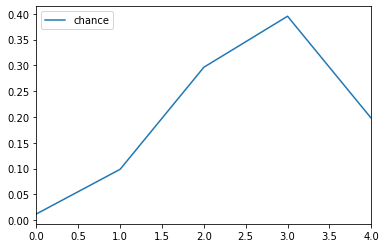

In [39]:
df.plot() ; None

### SciPy Stats

Today we went through the scipy stats implementation of [binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html).
It wraps up everything above in a nice object.
I'm going to duplicate the calculations above now.

In [40]:
from scipy.stats import binom

This is a binomial distribution for 4 attempts where the chance of an event occurring is `4/6`:

In [47]:
harlequin_hit = binom(4, 4/6)

The returned object is complex and can describe itself and run simulations.
The `rvs` function provides a count of events for a simulation.
The `pmf` function provides the chance for exactly `k` occurrences of the event in a simulation.
The `cdf` function provides the cumulative chance for `k` or less occurrences of the event.
The `sf` function provides the survival chance for more than `k` occurrences of the event.
You can use `mean`, `std` and `var` to get the mean, standard deviation and variance respectively.

In [48]:
[harlequin_hit.rvs() for _ in range(10)]

[2, 2, 2, 3, 3, 2, 4, 3, 2, 2]

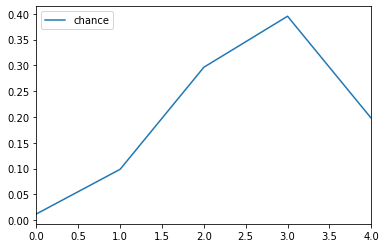

In [49]:
df = pd.DataFrame({
    'chance': [harlequin_hit.pmf(x) for x in range(5)]
})
df.plot() ; None

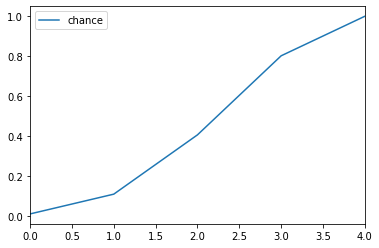

In [50]:
df = pd.DataFrame({
    'chance': [harlequin_hit.cdf(x) for x in range(5)]
})
df.plot() ; None

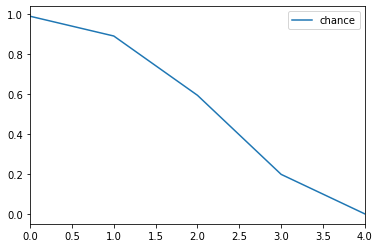

In [51]:
df = pd.DataFrame({
    'chance': [harlequin_hit.sf(x) for x in range(5)]
})
df.plot() ; None

In [52]:
harlequin_hit.mean(), harlequin_hit.std(), harlequin_hit.var()

(2.6666666666666665, 0.9428090415820634, 0.888888888888889)

### Product of Binomials

I asked about this as it would be nice to have two graphs and see what happens when you multiply them together.
The fact is that this is just a case of taking the product of the probabilities (*note: see all of bayes w.r.t. independence*).
In this case all dice rolls are independent so we can just multiply the probabilities.

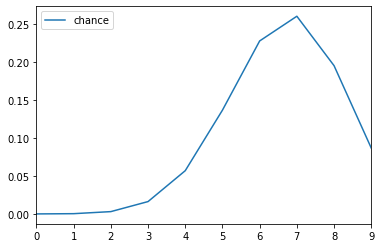

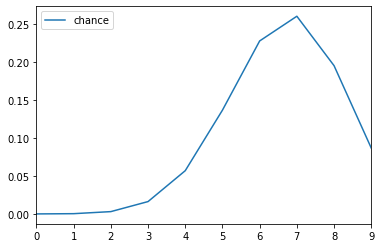

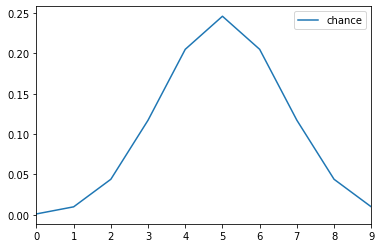

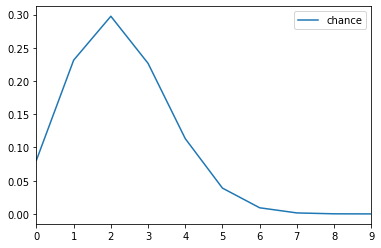

In [57]:
# Five Plague Guards shooting boltguns at short range. Per guard:
# Attacks 2
# To Hit 3+
# To Wound 3+
# Save 4+

def plot(binomial, outcomes):
    df = pd.DataFrame({
        'chance': [binomial.pmf(x) for x in range(outcomes)]
    })
    df.plot()

attacks = 5 * 2
to_hit = binom(attacks, 4/6)
to_wound = binom(attacks, 4/6)
to_injure = binom(attacks, 3/6)

composite = binom(attacks, (4*4*3) / (6*6*6))

plot(to_hit, attacks)
plot(to_wound, attacks)
plot(to_injure, attacks)
plot(composite, attacks)

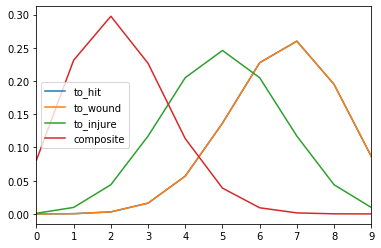

In [60]:
df = pd.DataFrame({
    'to_hit': [to_hit.pmf(x) for x in range(attacks)],
    'to_wound': [to_wound.pmf(x) for x in range(attacks)],
    'to_injure': [to_injure.pmf(x) for x in range(attacks)],
    'composite': [composite.pmf(x) for x in range(attacks)],
})
df.plot() ; None

In [61]:
to_hit.mean(), to_wound.mean(), to_injure.mean(), composite.mean()

(6.666666666666666, 6.666666666666666, 5.0, 2.2222222222222223)